---
title: Deep Music Genre Classification
author: Sophie Seiple
date: '2024-05-10'
image: "music.png"
description: "Using spotify data and neural networks to classify songs."
format: html
---

## Abstract

This blog post presents an approach to music genre classification using deep learning on a dataset of song information from Spotify. I trained three neural network models: one using only the song lyrics, one using only the engineered numeric features, and one combining both the lyrics and engineered features. The lyrics are preprocessed by filtering for common tokens and employing embedding layers, while the engineered features utilize fully-connected layers. The models' genre classification performance is evaluated on a validation set and compared to a baseline rate. Additionally, the post explores visualizing the learned word embeddings to gain insights into the models. I created extra visualizations to investigate potential relationships between genres and engineered features like danceability, sadness, and audio characteristics over time.

First, I read in and examind the data.

In [80]:
import pandas as pd
import numpy as np

# read in data
url = "https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/datasets/tcc_ceds_music.csv"
df = pd.read_csv(url)

In [2]:
df.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.0


In [27]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings("ignore", category = UserWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Next I wanted to see what our baseline accuracy was, i.e. the accuracy we get from guessting the same label everytime.

In [29]:
df.groupby("genre").size() / len(df)

genre
blues      0.162273
country    0.191915
hip hop    0.031862
jazz       0.135521
pop        0.248202
reggae     0.088045
rock       0.142182
dtype: float64

We want our model accuracy to be >24%, since this would be equivalent to predicting pop every single time.

Next, I encoded the genre labels so that we could feed them into our model.

In [30]:
genres = {
    "blues"   : 0,
    "country" : 1, 
    "hip hop" : 2,
    "jazz"    : 3,
    "pop"     : 4,
    "reggae"  : 5, 
    "rock"    : 6,
}

df = df[df["genre"].apply(lambda x: x in genres.keys())]

df["genre"] = df["genre"].apply(genres.get)

Then I implemented a slightly modified version of the data retrieving function from the lecture notes.

In [31]:
from torch.utils.data import Dataset, DataLoader

class DataFromDF(Dataset):
    def __init__(self, df):
        self.df = df 

    def __getitem__(self, index):
        # return lyrics, genre, and engineered features via their indices
        return self.df.iloc[index, 5], self.df.iloc[index, 4], self.df.iloc[index, 6:28]

    def __len__(self):
        return len(self.df)


I then split the data into training and testing data, and retrieved the columns we wanted to focus on using our function for both training and testing.

In [32]:
df_train, df_val = train_test_split(df,shuffle = True, test_size = 0.2)
# retrieve data
train_data = DataFromDF(df_train)
val_data   = DataFromDF(df_val)

Next, I built a tokenizer so that we could use the lyrics features of the songs in our model. This code is also adapted from the lecture notes.

In [33]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

In [34]:
# function to generate tokens from a data iterator
def yield_tokens(data_iter):
    for text, features, lab in data_iter:
        yield tokenizer(text)

# build vocabulary from tokens generated by the yield_tokens function
vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"], min_freq = 50)
vocab.set_default_index(vocab["<unk>"])

In [35]:
max_len = 30
num_tokens = len(vocab.get_itos())

# function to process text data into token indices
# also taken from the lecture notes on text processing
def text_pipeline(x):
    tokens = vocab(tokenizer(x))
    y = torch.zeros(max_len, dtype=torch.int64) + num_tokens
    if len(tokens) > max_len:
        tokens = tokens[0:max_len]
    y[0:len(tokens)] = torch.tensor(tokens,dtype=torch.int64)
    return y

# function to process label data
label_pipeline = lambda x: int(x)

This is an example of using this text pipeline on a few words of a song from our dataset:

In [37]:
text_pipeline("chaos come clarity")

tensor([2267,    4,    0, 2904, 2904, 2904, 2904, 2904, 2904, 2904, 2904, 2904,
        2904, 2904, 2904, 2904, 2904, 2904, 2904, 2904, 2904, 2904, 2904, 2904,
        2904, 2904, 2904, 2904, 2904, 2904])

In [44]:
# function to collate a batch of data samples
# also adapted from the lecture notes on text processing
def collate_batch(batch):

     # initialize empty lists to store labels, processed text, and features
    label_list, text_list, features_list = [], [], []
    
    # iterate over each sample in the batch
    for (text, label, features) in batch:
        # process label and add to the label list
        label_list.append(label_pipeline(label))

        # process text and add to the text list
        processed_text = text_pipeline(text)
        text_list.append(processed_text)

        # convert features to torch tensor and add to the features list
        features_list.append(torch.tensor(features))  # Convert features to torch.int64

    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.stack(text_list)
    features_list = torch.stack(features_list)  # Stack features tensors

    # return the processed batch: text tensor, label tensor, and features tensor
    return text_list, label_list, features_list 

Next I set up my dataloaders from PyTorch's DataLoader class.

In [45]:
# DataLoader for the training dataset
train_loader = DataLoader(train_data, batch_size=10, shuffle=True, collate_fn=collate_batch)

# DataLoader for the validation dataset
val_loader = DataLoader(val_data, batch_size=10, shuffle=True, collate_fn=collate_batch)

The first network I defined was the network that uses only the lyric data, this was my TextNet clas. This code was also adapted from our lecture notes on text processing.

In [46]:
from torch import nn

class TextNet(nn.Module):
    
    # constructor method, initializing the layers
    def __init__(self, vocab_size, embedding_dim, num_class):
        super().__init__()
        
        # define the embedding layer
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim)
        # define the dropout layer
        self.dropout = nn.Dropout (p=0.2)
        # define the fully connected layer
        self.fc = nn.Linear(embedding_dim, num_class)
            
    # method defining how data flows through the network
    def forward(self, text):

        # pass the input text through the embedding layer
        text = self.embedding(text)
        # apply dropout to the embedded text
        text = self.dropout(text)
        # compute the mean across the sequence dimension
        text = text.mean(axis=1)
        # pass the result through the fully connected layer
        text = self.fc(text)   

        return text
        

Next I defined the neural network that we'll use for our engineered features only model, this was my FeaturesNet class.

In [47]:
class FeaturesNet(nn.Module):

    # constructor method, initializing the layers
    def __init__(self, size, num_class):
        super().__init__()

        # define the feature model as a sequence of layers
        self.featmodel = nn.Sequential(nn.Linear(size, 128), nn.ReLU(), nn.Dropout(0.2), nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 32), nn.ReLU(), nn.Dropout(0.2), nn.Linear(32, 16), nn.ReLU(), nn.Dropout(0.2), nn.Linear(16, num_class),
            nn.Softmax(dim=1))
        
    # method defining how data flows through the network 
    def forward(self, feats):

        # convert feats to float type
        feats = feats.float()
        # flatten the features tensor
        feats = torch.flatten(feats, 1)
        # pass the flattened features through the feature model
        feats = self.featmodel(feats)

        return feats

Lastly, I defined a network that is able to use both lyrics and features, this was my CombinedNet class.

In [77]:
class CombinedNet(nn.Module):

    # constructor method, initializing the layers
    def __init__(self, vocab_size, embedding_dim, num_features, num_class):
        super().__init__()

        # same process as in the original lyric model
        self.embedding = nn.Embedding(vocab_size+1, embedding_dim)
        self.dropout = nn.Dropout (p=0.2)
        self.text_fc = nn.Linear(embedding_dim, 128)

        # similar model to the original feature only model
        self.engineered_model = nn.Sequential(nn.Linear(num_features, 256), nn.ReLU(), nn.Dropout(0.2), nn.Linear(256, 128))

        # fully connected layer for combining text and engineered features
        self.combine_fc = nn.Linear(3968, 64)
        # output fully connected layer
        self.output_fc = nn.Linear(64, num_class)
        # softmax activation for classification output
        self.softmax = nn.Softmax(dim=1)

    # method defining how data flows through the network
    def forward(self, text, features):

        # similar to lyrics only model
        text_em = self.embedding(text)
        text_dr = self.dropout(text_em)
        text_processed = self.text_fc(text_dr)
        text_processed = torch.flatten(text_processed, 1)


        # similar to features only model
        features = features.float()
        engineered_processed = self.engineered_model(features)

        # concatenate text and engineered features
        cat = torch.cat((text_processed, engineered_processed), dim=1)

        # process combined features through the output fully connected layer
        cat = self.combine_fc(cat)
        output = self.output_fc(cat)
        output = self.softmax(output)

        return output

Then I defined my training and evaluation methods for all three models, again adapted from our lecture on text processing. I use one training and evaluation method for all three of my neural networks by taking in a state parameter that tells us what kind of information needs to be passed to the model.

In [49]:
import time

def train(model, dataloader, optimizer, loss_fn, epoch, state='both'):
    epoch_start_time = time.time()
    # keep track of some counts for measuring accuracy
    total_acc, total_count = 0, 0
    log_interval = 300
    start_time = time.time()

    # iterate over batches in the dataloader
    for idx, (text, label, features) in enumerate(dataloader):
        # zero gradients
        optimizer.zero_grad()

        # depending on the given state (what the model should be allowed to use)
        if state == 'both':
            predicted_label = model(text, features)
        elif state == 'lyrics':
            predicted_label = model(text)
        elif state == 'features':
            predicted_label = model(features)
            
        # evaluate loss on prediction
        loss = loss_fn(predicted_label, label)

        # compute gradient
        loss.backward()
        
        # take an optimization step
        optimizer.step()

        # for printing accuracy
        total_acc   += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        
    print(f'| epoch {epoch:3d} | train accuracy {total_acc/total_count:8.3f} | time: {time.time() - epoch_start_time:5.2f}s')
    
def evaluate(model, dataloader, state='both'):
    total_acc, total_count = 0, 0

    # iterate over batches in the dataloader
    with torch.no_grad():
        for idx, (text, label, features) in enumerate(dataloader):
            # depending on the given state (what the model should be allowed to use) 
            if state == 'both':
                predicted_label = model(text, features)
            elif state == 'lyrics':
                predicted_label = model(text)
            elif state == 'features':
                predicted_label = model(features)
            
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count


Finally, I defined my outer loop, which makes it easy to create and train any of the three models with a single function. 

In [55]:
def outer_loop(train_loader, val_loader, state='both'):

    # define parameters according to what we know of the data
    vocab_size = len(vocab)
    embedding_dim = 3
    num_features = 22
    num_classes = 7

     # train a model based on the specified state
    if state == 'both':
        # use combined class
        model = CombinedNet(vocab_size, embedding_dim, num_features, num_classes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
        loss_fn = torch.nn.CrossEntropyLoss()

        # training loop
        EPOCHS = 50
        for epoch in range(1, EPOCHS + 1):
            train(model, train_loader, optimizer, loss_fn, epoch, 'both')

        # evaluate and print accuracy on validation set
        print('Accuracy: ', evaluate(model, val_loader, state='both'))
        return model
    
    if state == 'lyrics':
        # use lyrics class
        model = TextNet(vocab_size, embedding_dim, num_classes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = torch.nn.CrossEntropyLoss()

        # training loop
        EPOCHS = 50
        for epoch in range(1, EPOCHS + 1):
            train(model, train_loader, optimizer, loss_fn, epoch, 'lyrics')

        # evaluate and print accuracy on validation set
        print('Accuracy: ', evaluate(model, val_loader, state='lyrics'))
        return model

    if state == 'features':
        # use features class
        model = FeaturesNet(num_features, num_classes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = torch.nn.CrossEntropyLoss()

        # training loop
        EPOCHS = 50
        for epoch in range(1, EPOCHS + 1):
            train(model, train_loader, optimizer, loss_fn, epoch, 'features')

        # evaluate and print accuracy on validation set
        print('Accuracy: ', evaluate(model, val_loader, state='features'))
        return model
    

With all of these function defined, I can move on to training my models and exploring their accuracies.

## Lyrics Only

The first model I looked at was the model that only considered the input of lyrics.

In [29]:
lyric_model = outer_loop(train_loader, val_loader, 'lyrics')

/var/folders/b9/j0x1vdx94513n863t09wz2d80000gn/T/ipykernel_41870/1069164222.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features_list.append(torch.tensor(features))  # Convert features to torch.int64


| epoch   1 | train accuracy    0.228 | time:  4.69s
| epoch   2 | train accuracy    0.248 | time:  4.61s
| epoch   3 | train accuracy    0.255 | time:  4.52s
| epoch   4 | train accuracy    0.266 | time:  4.57s
| epoch   5 | train accuracy    0.275 | time:  4.46s
| epoch   6 | train accuracy    0.285 | time:  4.43s
| epoch   7 | train accuracy    0.297 | time:  4.69s
| epoch   8 | train accuracy    0.303 | time:  4.69s
| epoch   9 | train accuracy    0.312 | time:  4.53s
| epoch  10 | train accuracy    0.317 | time:  4.54s
| epoch  11 | train accuracy    0.321 | time:  4.65s
| epoch  12 | train accuracy    0.326 | time:  4.60s
| epoch  13 | train accuracy    0.333 | time:  4.62s
| epoch  14 | train accuracy    0.340 | time:  4.60s
| epoch  15 | train accuracy    0.344 | time:  4.65s
| epoch  16 | train accuracy    0.350 | time:  4.66s
| epoch  17 | train accuracy    0.350 | time:  4.67s
| epoch  18 | train accuracy    0.355 | time:  4.71s
| epoch  19 | train accuracy    0.361 | time: 

Our resulting neural network is not incredibly accurate, only classifying songs correctly around 32.47% of the time. However, this is still 8% better than our baseline measure of 24%, so the model is doing better than it would be guessing the same label every time.

## Features Only

Next, I looked at the model that only considered features.

In [30]:
features_model = outer_loop(train_loader, val_loader, 'features')

/var/folders/b9/j0x1vdx94513n863t09wz2d80000gn/T/ipykernel_41870/1069164222.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features_list.append(torch.tensor(features))  # Convert features to torch.int64


| epoch   1 | train accuracy    0.243 | time:  5.39s
| epoch   2 | train accuracy    0.249 | time:  5.38s
| epoch   3 | train accuracy    0.259 | time:  5.38s
| epoch   4 | train accuracy    0.273 | time:  6.85s
| epoch   5 | train accuracy    0.286 | time:  5.72s
| epoch   6 | train accuracy    0.287 | time:  5.47s
| epoch   7 | train accuracy    0.299 | time:  5.66s
| epoch   8 | train accuracy    0.301 | time:  5.49s
| epoch   9 | train accuracy    0.302 | time:  5.57s
| epoch  10 | train accuracy    0.302 | time:  5.70s
| epoch  11 | train accuracy    0.308 | time:  5.64s
| epoch  12 | train accuracy    0.310 | time:  5.47s
| epoch  13 | train accuracy    0.310 | time:  5.43s
| epoch  14 | train accuracy    0.311 | time:  5.41s
| epoch  15 | train accuracy    0.309 | time:  5.41s
| epoch  16 | train accuracy    0.313 | time:  5.47s
| epoch  17 | train accuracy    0.313 | time:  5.43s
| epoch  18 | train accuracy    0.308 | time:  5.41s
| epoch  19 | train accuracy    0.314 | time: 

Again, our accuracy is relatively low, but we are able to do better than the baseline accuracy of 24%, so our model is learning.

## Using Both

Lastly, I created and trained the model that uses both features and lyrics in classification.

In [78]:
outer_loop(train_loader, val_loader, 'both') 

/var/folders/b9/j0x1vdx94513n863t09wz2d80000gn/T/ipykernel_42158/1069164222.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features_list.append(torch.tensor(features))  # Convert features to torch.int64


| epoch   1 | train accuracy    0.240 | time:  6.47s
| epoch   2 | train accuracy    0.250 | time:  6.20s
| epoch   3 | train accuracy    0.251 | time:  6.38s
| epoch   4 | train accuracy    0.254 | time:  6.31s
| epoch   5 | train accuracy    0.256 | time:  6.42s
| epoch   6 | train accuracy    0.257 | time:  6.18s
| epoch   7 | train accuracy    0.262 | time:  6.25s
| epoch   8 | train accuracy    0.260 | time:  6.28s
| epoch   9 | train accuracy    0.262 | time:  6.78s
| epoch  10 | train accuracy    0.262 | time:  6.60s
| epoch  11 | train accuracy    0.264 | time:  6.64s
| epoch  12 | train accuracy    0.263 | time:  6.86s
| epoch  13 | train accuracy    0.264 | time:  6.77s
| epoch  14 | train accuracy    0.265 | time:  7.41s
| epoch  15 | train accuracy    0.268 | time:  7.16s
| epoch  16 | train accuracy    0.266 | time:  6.85s
| epoch  17 | train accuracy    0.265 | time:  7.09s
| epoch  18 | train accuracy    0.265 | time:  7.03s
| epoch  19 | train accuracy    0.266 | time: 

CombinedNet(
  (embedding): Embedding(2905, 3)
  (dropout): Dropout(p=0.2, inplace=False)
  (text_fc): Linear(in_features=3, out_features=128, bias=True)
  (engineered_model): Sequential(
    (0): Linear(in_features=22, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
  )
  (combine_fc): Linear(in_features=3968, out_features=64, bias=True)
  (output_fc): Linear(in_features=64, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)

Interestingly, my combined model did worse than both of the seperate models, but still 1% better than our baseline accuracy.

## Examining Word Embedding

Next, I created a few visualizations to explore the word embedding that my lyrics network generated.

In [ ]:
from sklearn.decomposition import PCA

# extract the word embeddings from the lyric_model and convert to NumPy array
emmat = lyric_model.embedding.cpu().weight.data.numpy()

# initialize PCA with 2 components for 2D visualization
pca = PCA(n_components=2)
# perform PCA on the word embeddings
weights = pca.fit_transform(emmat)

# get the tokens (words) from the vocabulary
tokens = vocab.get_itos()
tokens.append(" ")
# create a DataFrame to store the word embeddings and their PCA-reduced dimensions
embed_df = pd.DataFrame({
    'word' : tokens,
    'w0' : weights[:,0],
    'w1' : weights[:,1]
})

embed_df.head()

,word,w0,w1
0,<unk>,0.472313,-0.003740
1,know,0.069357,-0.285091
2,like,0.092207,-0.414570
3,time,-0.125206,-0.341289
4,come,0.067297,-0.144520


This is a dataframe representing our embedding results, with each word and its related position. I then used this dataframe to visualize any patterns in our embedding.

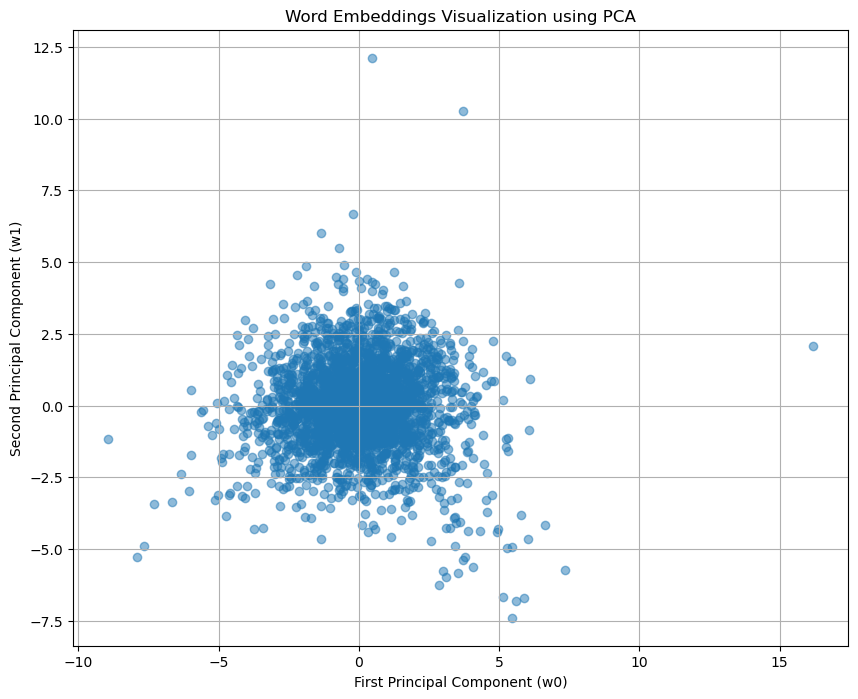

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 8))
plt.scatter(embed_df['w0'], embed_df['w1'], alpha=0.5)


plt.xlabel('First Principal Component (w0)')
plt.ylabel('Second Principal Component (w1)')
plt.title('Word Embeddings Visualization using PCA')
plt.grid(True)
plt.show()

No patterns were immediately clear in this graph, so I moved on to selecting a few specific words and examining their relationships to each other. The first group I visualized was words that I recognized as nicknames, as I wanted to see if they were all close together, or if some nicknames were closer to each other than others.

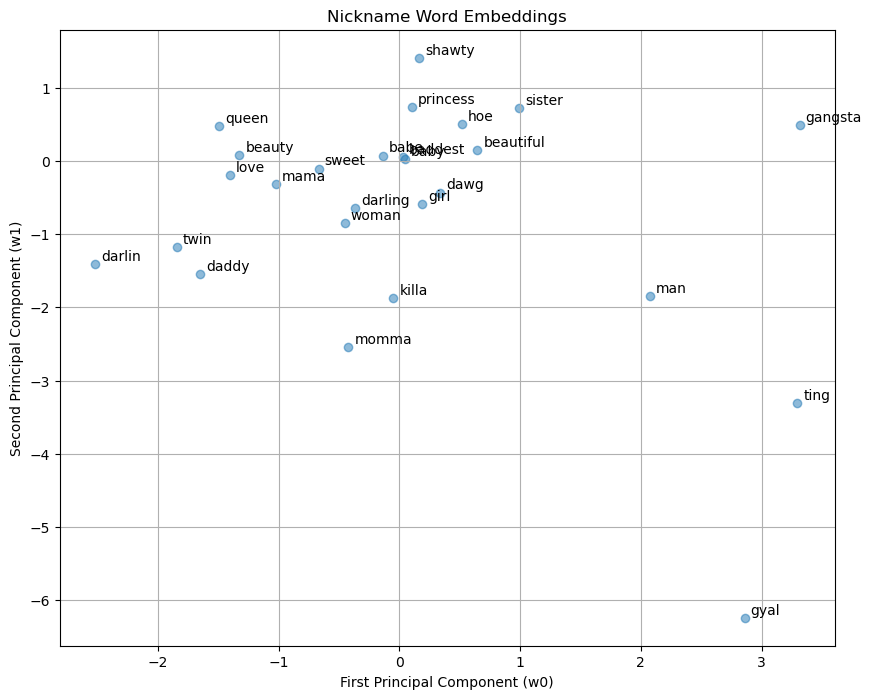

In [ ]:
# nicknames for people that appear in songs
group1 = ['baby', 'girl', 'love', 'sweet', 'woman', 'darling', 'mama', 'beautiful', 'babe', 'daddy', 'queen', 'hoe', 'darlin', 'momma', 'beauty', 'sister', 'gyal', 'shawty', 
          'dawg', 'ting', 'gangsta', 'baddest', 'princess', 'twin', 'man', 'killa']
offset = 0.05

# plot subset of nicknames
group1_df = embed_df[embed_df['word'].isin(group1)]
plt.figure(figsize=(10, 8))
plt.scatter(group1_df['w0'], group1_df['w1'], alpha=0.5)

# add word to plot
for _, row in group1_df.iterrows():
    plt.annotate(row['word'], (row['w0'] + offset, row['w1'] + offset))  # Add offset to coordinates

plt.xlabel('First Principal Component (w0)')
plt.ylabel('Second Principal Component (w1)')
plt.title('Nickname Word Embeddings')
plt.grid(True)
plt.show()

All of the nicknames seem somewhat close together, which makes sense considering they all have related meanings. There are a few outliers away from the majority of nicknames, but I didn't immeadiately see a shared characeristic between them that made them outliers.

Next I plotted words I associated with country music against words I associated with pop music.

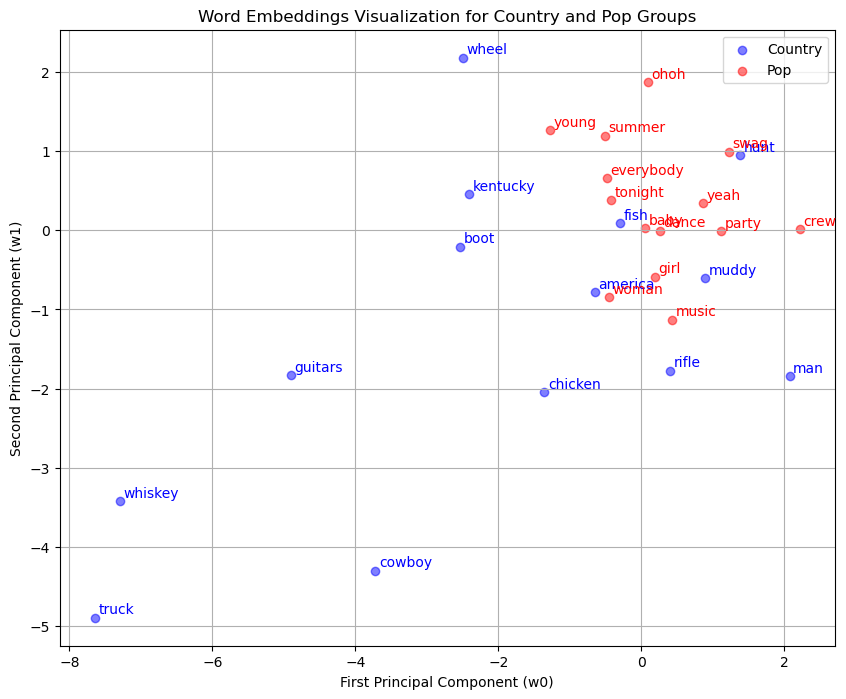

In [ ]:
# words I think appear in country songs
country = ['truck', 'muddy', 'boot', 'rifle', 'hunt', 'fish', 'man', 'america', 'wheel', 'kentucky', 'guitars', 'whiskey', 'chicken', 'cowboy']
# words I think appear in pop songs
pop = ['girl', 'woman', 'tonight', 'baby', 'yeah', 'swag', 'music', 'party', 'everybody', 'young', 'summer', 'ohoh', 'crew', 'dance']

# offset for graph labels
offset = 0.05

# create plottable df for the two word groups
country_df = embed_df[embed_df['word'].isin(country)]
pop_df = embed_df[embed_df['word'].isin(pop)]

plt.figure(figsize=(10, 8))
plt.scatter(country_df['w0'], country_df['w1'], alpha=0.5, color='blue')

for _, row in country_df.iterrows():
    plt.annotate(row['word'], (row['w0'] + offset, row['w1'] + offset), color='blue')

plt.scatter(pop_df['w0'], pop_df['w1'], alpha=0.5, color='red')
for _, row in pop_df.iterrows():
    plt.annotate(row['word'], (row['w0'] + offset, row['w1'] + offset), color='red') 


plt.xlabel('First Principal Component (w0)')
plt.ylabel('Second Principal Component (w1)')
plt.title('Word Embeddings Visualization for Country and Pop Groups')
plt.grid(True)
plt.legend(['Country', 'Pop'])
plt.show()

Interestingly, the words I associate with pop music are all pretty close together, which would indicate that they are related in terms of guessing the genre, but the words I would associate with country music are much more spread out. The close embedding between the words 'america' and 'woman' was also quite surprising.

## Optional Graphs

#### 1. Has pop music gotten more danceable over time in this sample, according to Spotify’s definition of danceability?

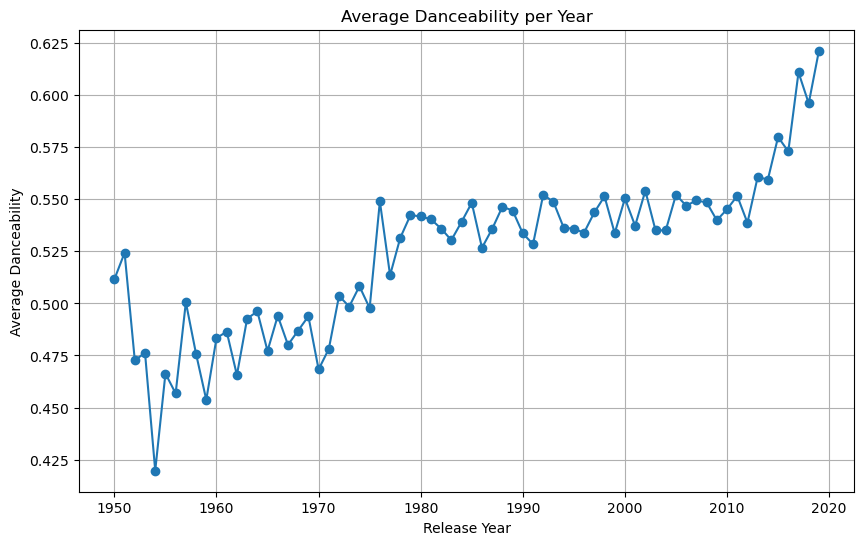

In [ ]:
# finding average danceability per release year
average_danceability_per_year = df.groupby('release_date')['danceability'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_danceability_per_year.index, average_danceability_per_year.values, marker='o')
plt.xlabel('Release Year')
plt.ylabel('Average Danceability')
plt.title('Average Danceability per Year')
plt.grid(True)
plt.show()

This graph shows that over time songs have become more danceable according to spotify's definition.

#### 2. Does blues music tend to have more sadness than other genres? Does pop or rock have more energy?

In [82]:
cols = ['genre', 'dating', 'violence', 'world/life', 'night/time','shake the audience','family/gospel', 'romantic', 'communication','obscene', 'music', 'movement/places', 'light/visual perceptions','family/spiritual', 'like/girls', 'sadness', 'feelings', 'danceability','loudness', 'acousticness', 'instrumentalness', 'valence', 'energy']      
subset_df = df[cols]
average_by_genre = subset_df.groupby('genre').mean()

subset_avg = average_by_genre[['sadness', 'energy']]
subset_avg

,sadness,energy
genre,,
blues,0.113511,0.581534
country,0.165922,0.466350
hip hop,0.036589,0.703236
jazz,0.124067,0.463430
pop,0.142083,0.601097
reggae,0.078312,0.589931
rock,0.133539,0.700954


Country music ended up having the highest average "sadness" classification, while hip-hohp had the highest average energy value, but came in very close to rock.

#### 3. Are acousticness and instrumentalness similar features? Can you find any patterns in when they disagree?

For this question I focused on country and jazz specifically after finding they were the most common in these two genres.

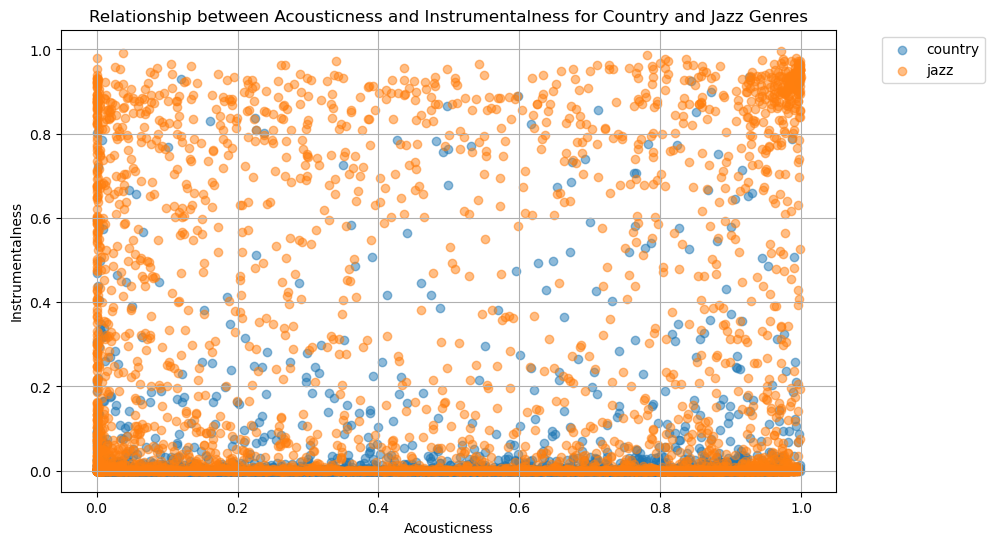

In [ ]:
# focusing only on country and jazz
subset_df = df[df['genre'].isin(['country', 'jazz'])]

# Scatter plot of "acousticness" against "instrumentalness" for country and jazz genres
plt.figure(figsize=(10, 6))
for genre in ['country', 'jazz']:
    genre_df = subset_df[subset_df['genre'] == genre]
    plt.scatter(genre_df['acousticness'], genre_df['instrumentalness'], alpha=0.5, label=genre)

plt.xlabel('Acousticness')
plt.ylabel('Instrumentalness')
plt.title('Relationship between Acousticness and Instrumentalness for Country and Jazz Genres')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


This graph didn't show any immeadiately clear pattens, so I wanted to look more specifically at what genres appeared at the extremes (high acoustic and low instumental and vice versa).

In [ ]:
# subsetting data to focus on engineered features
cols = ['genre', 'dating', 'violence', 'world/life', 'night/time','shake the audience','family/gospel', 'romantic', 'communication','obscene', 'music', 'movement/places', 'light/visual perceptions','family/spiritual', 'like/girls', 'sadness', 'feelings', 'danceability','loudness', 'acousticness', 'instrumentalness', 'valence', 'energy']      
subset_df = df[cols]

# Define thresholds for high and low instrumentalness and acousticness
high_instrumental_threshold = 0.8
low_instrumental_threshold = 0.2
high_acoustic_threshold = 0.8
low_acoustic_threshold = 0.2

# new subsets containing the high inst. and low acoustic songs and vice versa
high_instr_low_acoustic = subset_df[(subset_df['instrumentalness'] > high_instrumental_threshold) & (subset_df['acousticness'] < low_acoustic_threshold)]
high_acoustic_low_instr = subset_df[(subset_df['acousticness'] > high_acoustic_threshold) & (subset_df['instrumentalness'] < low_instrumental_threshold)]

# find most frequent genre in each subset
genre_counts = high_instr_low_acoustic['genre'].value_counts()
most_frequent_genre = genre_counts.idxmax()
print("Most frequent appearing genre within low acoustic, high instrumental:", most_frequent_genre)

genre_counts = high_acoustic_low_instr['genre'].value_counts()
most_frequent_genre = genre_counts.idxmax()
print("Most frequent appearing genre within high acoustic, low instrumental:", most_frequent_genre)


Most frequent appearing genre within low acoustic, high instrumental: jazz
Most frequent appearing genre within high acoustic, low instrumental: country


This finding made sense to me, if Spotify used instumentalness to measure the presence of instruments compared to voice, and and acoustic to measure the presence of voice with fewer instuments.

## Discussion

In implementing this music genre classification task, I gained several insights through the process of building and evaluating the three neural network models. While the accuracy results were not extraordinary, with all three models scoring in the 25-30% range, they did exceed the baseline rate of 24% for randomly guessing among the 7 genres. This suggests that the models were able to extract and utilize meaningful patterns from the lyrics and engineered features, even if their predictive performance has room for improvement. One surprising finding was that combining both the text lyrics and numeric engineered features in the third model did not lead to a significant boost over the individual models. This could potentially be addressed by more advanced architectures for the combined network. Visualizing the learned word embeddings from the lyrics model revealed some unexpected clusterings, like outliers in nicknames. Overall, while beating the baseline, the relatively low accuracies showed that perfect classification remains a challenge requiring more sophisticated techniques or richer data sources. Throughout the process of implementing these models, I learned a lot about the uses of the individual layers of neural networks and the differing tasks for which they are optimal.